In [249]:
# Import libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Connect to PostgreSQL server
import os
from dotenv import load_dotenv
load_dotenv()
from pangres import upsert
from sqlalchemy import text, create_engine

db_username = os.environ.get('db_username')
db_password = os.environ.get('db_password')
db_host = os.environ.get('db_host')
db_port = os.environ.get('db_port')
db_name = os.environ.get('db_name')

def create_db_connection_string(db_username, db_password, db_host, db_port, db_name):
    connection_url = 'postgresql+psycopg2://' + db_username + ':' + db_password + '@' + db_host + ':' + db_port + '/' + db_name
    return connection_url

conn = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)

db_engine = create_engine(conn, pool_recycle = 3600)

# Create DataFrame
with db_engine.connect() as connection:
    df = pd.read_sql(text('select * from soloq.matchesv2'), connection)


# Data Cleaning

In [160]:
# Replacing item ids with name in game
import requests
items = "https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/items.json"

items_json = requests.get(items).json()

def json_extract(obj, key):

    arr = []

    def extract(obj, arr, key):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == key:
                    arr.append(v)
                elif isinstance(v, (dict, list)):
                    extract(v, arr, key)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)

        return arr
    
    values = extract(obj, arr, key)
    return values

item_ids = json_extract(items_json, 'id')
item_names = json_extract(items_json, 'name')

item_dict = dict(map(lambda i, j :(i, j), item_ids, item_names))

In [161]:
# Map to items
item_features = ['item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']
df[item_features] = df[item_features].replace(item_dict)

# Exploratory Data Analysis

In [114]:
df.columns

Index(['uuid', 'matchId', 'teamId', 'gameDuration', 'gameVersion',
       'summonerName', 'puuid', 'lane', 'role', 'summonerLevel',
       'teamPosition', 'champExperience', 'champLevel', 'championName',
       'kills', 'deaths', 'assists', 'doubleKills', 'tripleKills',
       'quadraKills', 'pentaKills', 'largestKillingSpree', 'largestMultiKill',
       'killingSprees', 'firstBloodAssist', 'firstBloodKill', 'unrealKills',
       'totalDamageDealt', 'totalDamageDealtToChampions',
       'totalDamageShieldedOnTeammates', 'totalDamageTaken', 'totalHeal',
       'trueDamageDealt', 'trueDamageDealtToChampions', 'trueDamageTaken',
       'magicDamageDealt', 'magicDamageDealtToChampions', 'magicDamageTaken',
       'physicalDamageDealt', 'physicalDamageDealtToChampions',
       'physicalDamageTaken', 'baronKills', 'damageDealtToBuildings',
       'damageDealtToObjectives', 'damageDealtToTurrets', 'objectivesStolen',
       'objectivesStolenAssists', 'dragonKills', 'inhibitorKills',
       'i

In [115]:
df.shape

(248170, 83)

## Top features in determining champion

1. lane
2. kda
3. damage dealt
4. type of damage dealt
5. itemization
6. shield/heal
7. damage to towers
8. objective kills, wards placed?
9. buttons pressed?

In [124]:
champion_lane_role_counts = df.groupby(['championName', 'lane']).size().reset_index(name='Count')

most_popular_lane = champion_lane_role_counts.groupby('championName').apply(lambda x: x.loc[x['Count'].idxmax()]).reset_index(drop=True)

In [126]:
most_popular_lane

,championName,lane,Count
0,Aatrox,TOP,1633
1,Ahri,MIDDLE,1039
2,Akali,MIDDLE,1827
3,Akshan,MIDDLE,567
4,Alistar,BOTTOM,591
...,...,...,...
162,Zeri,BOTTOM,488
163,Ziggs,BOTTOM,312
164,Zilean,BOTTOM,454
165,Zoe,MIDDLE,377


# Items

In [162]:
items = ['item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']
for item in items:
    print(df[['championName', item]].value_counts()[:5])

championName  item0               
Lux           Zaz'Zak's Realmspike    1973
Senna         Bloodsong               1592
Zyra          Zaz'Zak's Realmspike    1363
Caitlyn       Doran's Blade           1324
MissFortune   Doran's Blade           1240
Name: count, dtype: int64
championName  item1              
Smolder       Essence Reaver         1972
MissFortune   Youmuu's Ghostblade    1888
Yone          Berserker's Greaves    1439
Yasuo         Berserker's Greaves    1430
Jhin          Youmuu's Ghostblade    1311
Name: count, dtype: int64
championName  item2                   
Smolder       Ionian Boots of Lucidity    1575
Lux           Sorcerer's Shoes            1501
Jhin          Boots of Swiftness          1493
Caitlyn       Berserker's Greaves         1424
Brand         Sorcerer's Shoes            1230
Name: count, dtype: int64
championName  item3                   
MissFortune   The Collector               1214
Smolder       Navori Quickblades          1175
Jhin          The Col

# Damage

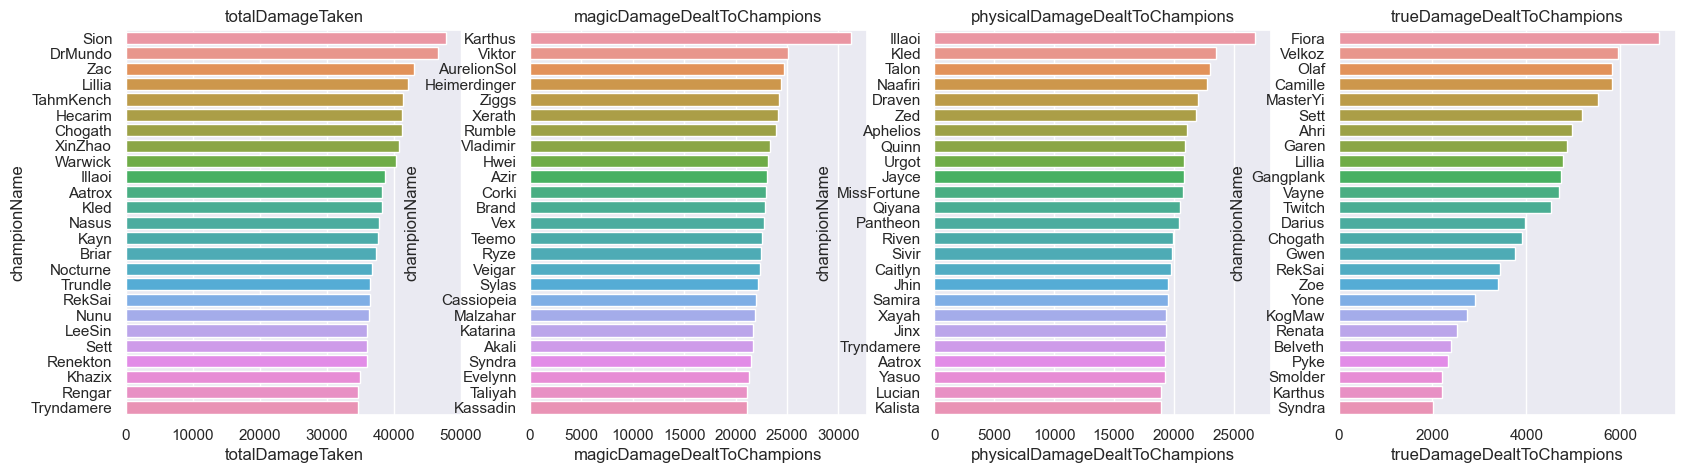

In [90]:
damage = ['totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions']

fig, axs = plt.subplots(1, len(damage), figsize=(20, 5))
for i, feature in enumerate(damage):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)

# Healing/Shielding

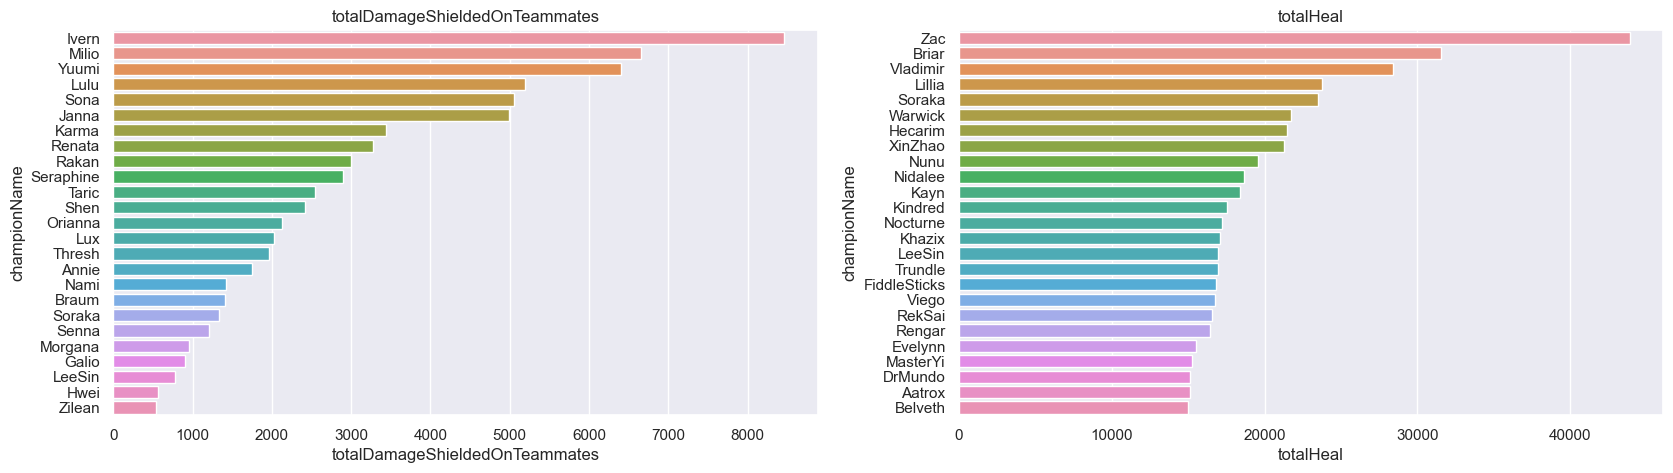

In [89]:
heal_shield = ['totalDamageShieldedOnTeammates','totalHeal']

fig, axs = plt.subplots(1, len(heal_shield), figsize=(20, 5))
for i, feature in enumerate(heal_shield):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)

# Objectives

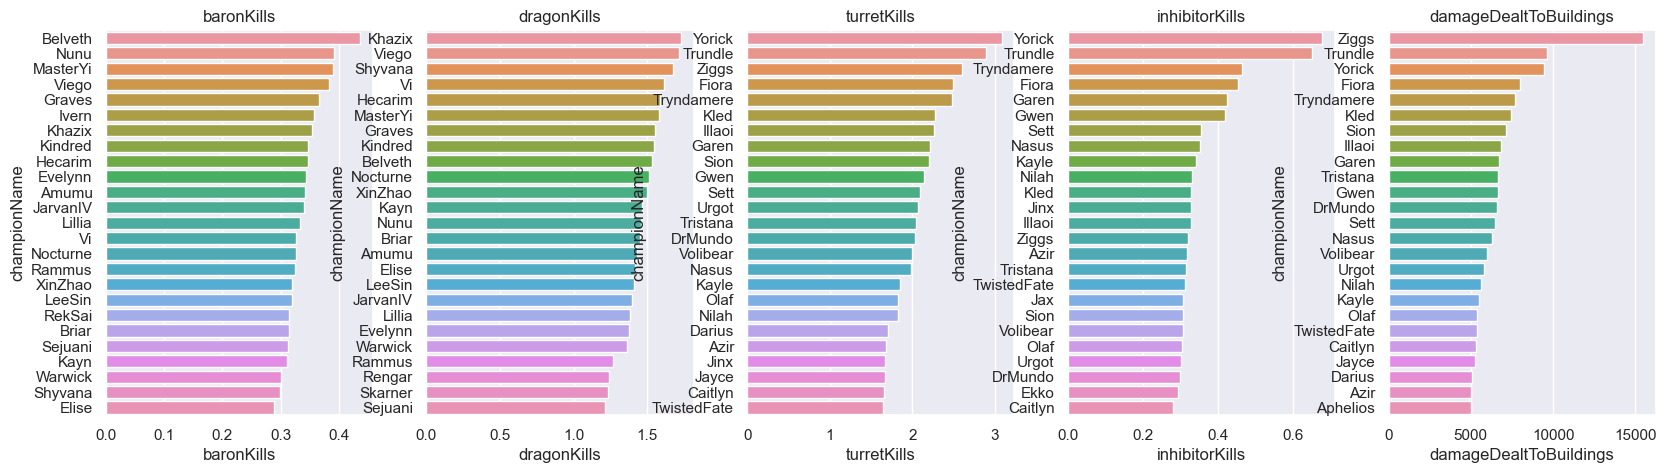

In [185]:
objectives = ['baronKills', 'dragonKills', 'turretKills', 'inhibitorKills', 'damageDealtToBuildings']

fig, axs = plt.subplots(1, len(objectives), figsize=(20, 5))
for i, feature in enumerate(objectives):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)

# Other

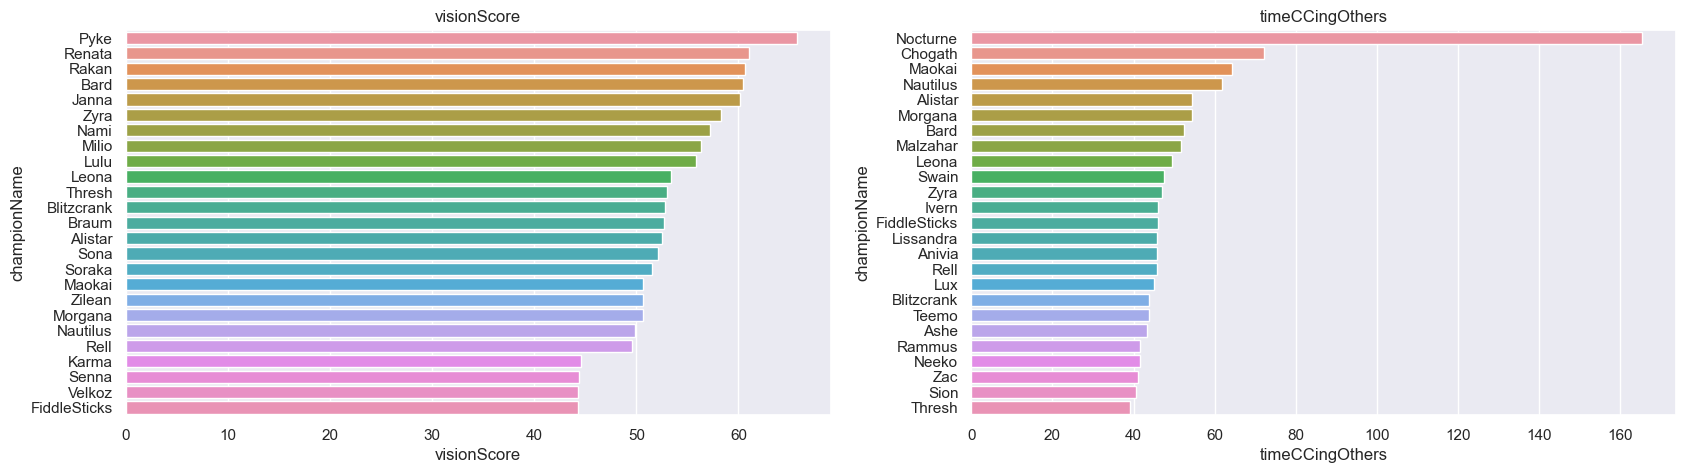

In [82]:
other = ['visionScore', 'timeCCingOthers']

fig, axs = plt.subplots(1, len(other), figsize=(20, 5))
for i, feature in enumerate(other):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)

# Feature Engineering
1. Classify champions as AP/AD
2. Classify champions as their class -> bruiser, tank, blah blah blah
3. 

In [220]:
# Classifying champions as ap champs if they deal more magic than physical damage
df['ap'] = (df['physicalDamageDealtToChampions'] < df['magicDamageDealtToChampions'])

# Same thing for ad
df['ad'] = (df['physicalDamageDealtToChampions'] > df['magicDamageDealtToChampions'])

# Objective Kills
df['objective_kills'] = df['baronKills'] + df['dragonKills']

# Turret Kills
df['building_kills'] = df['turretKills'] + df['inhibitorKills']

# Early game champion


## Data Preprocessing

In [221]:
# Import features
# important_features = [
#                    'visionScore', 'timeCCingOthers', 'baronKills', 'dragonKills', 'turretKills', 'damageDealtToBuildings',
#                    'totalDamageShieldedOnTeammates','totalHeal', 'totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions']
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
df['championName'] = label_encoder.fit_transform(df['championName'])
df['win'] = label_encoder.fit_transform(df['win'])
df['ap'] = label_encoder.fit_transform(df['ap'])
df['ad'] = label_encoder.fit_transform(df['ad'])



In [222]:
# Binning continuous variables
df['objective_kills'] = pd.cut(df['objective_kills'], bins = 5, labels = False)
df['building_kills'] = pd.cut(df['building_kills'], bins = 5, labels = False)

In [223]:
df['totalHeal'] = pd.cut(df['totalHeal'], bins = 5, labels = False)
df['trueDamageDealt'] = pd.cut(df['trueDamageDealt'], bins = 5, labels = False)
df['magicDamageDealt'] = pd.cut(df['magicDamageDealt'], bins = 5, labels = False)
df['physicalDamageDealt'] = pd.cut(df['physicalDamageDealt'], bins = 5, labels = False)
df['physicalDamageTaken'] = pd.cut(df['physicalDamageTaken'], bins = 5, labels = False)
df['totalDamageShieldedOnTeammates'] = pd.cut(df['totalDamageShieldedOnTeammates'], bins = 5, labels = False)

In [224]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding for nominal data
one_hot = OneHotEncoder(sparse_output=False)
encoded_columns = one_hot.fit_transform(df[['role', 'lane', 'teamPosition']])
encoded_df = pd.DataFrame(encoded_columns, columns = one_hot.get_feature_names_out(['role', 'lane', 'teamPosition']))

df = pd.concat([df, encoded_df], axis=1)

encoded_column_names = one_hot.get_feature_names_out(['role', 'lane', 'teamPosition'])
print(encoded_column_names)

# Drop the original categorical columns
df.drop(['role', 'lane', 'teamPosition'], axis=1, inplace=True)

['role_CARRY' 'role_DUO' 'role_NONE' 'role_SOLO' 'role_SUPPORT'
 'lane_BOTTOM' 'lane_JUNGLE' 'lane_MIDDLE' 'lane_NONE' 'lane_TOP'
 'teamPosition_' 'teamPosition_BOTTOM' 'teamPosition_JUNGLE'
 'teamPosition_MIDDLE' 'teamPosition_TOP' 'teamPosition_UTILITY']


In [226]:
important_features = ['visionScore', 'win', 'ap', 'ad', 
                      'item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'objective_kills',
                      'building_kills', 'totalHeal', 'trueDamageDealt', 'magicDamageDealt', 'physicalDamageDealt',
                      'physicalDamageTaken', 'totalDamageShieldedOnTeammates', 'role_CARRY', 'role_DUO', 'role_NONE', 'role_SOLO', 'role_SUPPORT',
 'lane_BOTTOM', 'lane_JUNGLE', 'lane_MIDDLE', 'lane_NONE', 'lane_TOP',
 'teamPosition_', 'teamPosition_BOTTOM', 'teamPosition_JUNGLE',
 'teamPosition_MIDDLE', 'teamPosition_TOP', 'teamPosition_UTILITY']


X = df[important_features]
y = df['championName']

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

model = RandomForestClassifier(random_state=1)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

In [229]:
model.fit(train_X, train_y)
preds = model.predict(val_X)
print(mean_absolute_error(val_y, preds))
print(model.score(train_X, train_y))

34.0565575487968
0.9812708526973518


In [245]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(val_y, preds)

In [246]:
accuracy

0.3943394097641958

In [248]:
from sklearn.metrics import classification_report
report = classification_report(val_y, preds)
print(report)

              precision    recall  f1-score   support

           0       0.37      0.55      0.44       561
           1       0.10      0.09      0.10       329
           2       0.24      0.43      0.31       608
           3       0.36      0.17      0.23       252
           4       0.03      0.01      0.02       172
           5       0.32      0.39      0.35       307
           6       0.26      0.21      0.23       192
           7       0.16      0.10      0.12       169
           8       0.09      0.02      0.04       214
           9       0.35      0.39      0.37       804
          10       0.35      0.45      0.40       398
          11       0.32      0.37      0.34       199
          12       0.43      0.43      0.43       312
          13       0.48      0.33      0.39       322
          14       0.24      0.27      0.26       390
          15       0.38      0.42      0.40       998
          16       0.02      0.01      0.01       131
          17       0.58    